In [401]:
from torchtext.data import get_tokenizer
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import spacy

from torchtext.vocab import build_vocab_from_iterator
%matplotlib inline 


In [402]:
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:   
    print("CUDA is not available. Training on CPU.")

CUDA is available. Training on GPU.


In [403]:
if torch.cuda.is_available():
    torch.set_default_device('cuda')

In [404]:
tokenizer = get_tokenizer("basic_english")

# Open the file and read the contents
with open('data/war_and_peace.txt', 'r') as file:
    content = file.read() 
    
tokens = tokenizer(content)

In [405]:
# eng = spacy.load("en_core_web_sm")
# 
# FILE_PATH = 'data/war_and_peace.txt'


In [406]:
# build the vocabulary of characters and mappings to/from integers
words = sorted(list(set(tokens)))
stoi = {s:i for i,s in enumerate(words)}
itos = {i:s for s,i in stoi.items()}

In [407]:
stoi

{'!': 0,
 '(': 1,
 ')': 2,
 '*': 3,
 '*catherine': 4,
 '*do': 5,
 '*kutúzov': 6,
 '*poisonous': 7,
 '*—as': 8,
 ',': 9,
 '-': 10,
 '.': 11,
 '000': 12,
 '07': 13,
 '1': 14,
 '10': 15,
 '100': 16,
 '102': 17,
 '10—annette': 18,
 '11': 19,
 '110': 20,
 '12': 21,
 '120': 22,
 '13': 23,
 '130': 24,
 '13th': 25,
 '140': 26,
 '15': 27,
 '15/4': 28,
 '150': 29,
 '15y': 30,
 '160': 31,
 '17': 32,
 '178': 33,
 '1789': 34,
 '1797': 35,
 '17th': 36,
 '18': 37,
 '1805': 38,
 '1805-6': 39,
 '1806': 40,
 '1807': 41,
 '1808': 42,
 '1809': 43,
 '1809—precede': 44,
 '1810': 45,
 '1811': 46,
 '1812': 47,
 '1812—the': 48,
 '1812—though': 49,
 '1813': 50,
 '1813—salute': 51,
 '1815': 52,
 '1820': 53,
 '18th': 54,
 '1st': 55,
 '2': 56,
 '20': 57,
 '217': 58,
 '22': 59,
 '22nd': 60,
 '23': 61,
 '23rd': 62,
 '24': 63,
 '24th': 64,
 '25': 65,
 '25th': 66,
 '26': 67,
 '27': 68,
 '27th': 69,
 '3': 70,
 '30': 71,
 '31': 72,
 '3rd': 73,
 '4': 74,
 '40': 75,
 '4th': 76,
 '4x': 77,
 '5': 78,
 '50': 79,
 '6': 80,
 '

In [408]:
vocab_size = len(stoi)

In [409]:
# build the dataset

# context length: how many characters we take to predict the next one
block_size = 4

X, Y = [], []

context = [0] * block_size

for token in tokens:
    ix = stoi[token]
    X.append(context)
    Y.append(ix)
    # print(", ".join(itos[i] for i in context), "--->", itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [410]:
occurrences = {}

for token in tokens:
    if stoi[token] in occurrences:
        occurrences[stoi[token]] += 1
    else:
        occurrences[stoi[token]] = 1

In [411]:
sorted_occurrences = sorted(occurrences.items(), key=lambda item: item[1], reverse=True)
sorted_occurrences

[(9, 39744),
 (17993, 34127),
 (11, 30659),
 (736, 21745),
 (18297, 16552),
 (12375, 14852),
 (101, 10351),
 (8322, 9668),
 (9118, 8837),
 (21712, 8611),
 (8592, 7957),
 (17982, 7697),
 (19733, 7322),
 (20108, 5633),
 (8135, 5351),
 (9707, 5031),
 (8416, 4695),
 (12156, 4598),
 (8523, 4566),
 (1226, 4497),
 (12449, 3958),
 (1128, 3945),
 (0, 3925),
 (2460, 3664),
 (7097, 3465),
 (16153, 3361),
 (8884, 3295),
 (20392, 3257),
 (9690, 3232),
 (100, 3135),
 (15530, 2834),
 (566, 2697),
 (7379, 2664),
 (1600, 2414),
 (19886, 2405),
 (2492, 2373),
 (18064, 2086),
 (19987, 2069),
 (18124, 2010),
 (12451, 2004),
 (19939, 2001),
 (19910, 1982),
 (8306, 1943),
 (13838, 1867),
 (16665, 1789),
 (13275, 1779),
 (722, 1613),
 (19181, 1550),
 (18005, 1512),
 (12525, 1503),
 (1661, 1474),
 (4871, 1469),
 (19924, 1453),
 (18003, 1437),
 (18041, 1364),
 (20251, 1350),
 (11176, 1263),
 (12469, 1263),
 (1013, 1224),
 (12620, 1223),
 (12199, 1216),
 (12096, 1174),
 (8912, 1156),
 (11805, 1135),
 (3964, 111

In [412]:
X.shape, Y.shape

(torch.Size([650138, 4]), torch.Size([650138]))

In [413]:
embedding_dim = 2
n_hidden = 1000

C = torch.randn(vocab_size, embedding_dim)

# because we use a block size of 3, the shape of the input layer will be 2*3 (embedding size * context size)
W1 = torch.randn((embedding_dim*block_size, n_hidden)) * (5/3) / ((embedding_dim * block_size)**0.5) * 0.2
b1 = torch.randn(n_hidden) * 0.0001
W2 = torch.randn((n_hidden, vocab_size))
b2 = torch.randn(vocab_size)

parameters = [C, W1, b1, W2, b2]

In [414]:
emb = C[X]
emb.shape

torch.Size([650138, 4, 2])

In [415]:
s = 0
for p in parameters:
    print(p.nelement())
    s += p.nelement()
    
print(f'sum of parameters: {s}')

43462
8000
1000
21731000
21731
sum of parameters: 21805193


In [416]:
for p in parameters:
    p.requires_grad = True

In [417]:
# exponentiated learning rate
ex_steps = 1000
lre = torch.linspace(-3, 0, ex_steps)
lrs = 10**lre

In [418]:
emb.shape

torch.Size([650138, 4, 2])

In [419]:
emb.view(-1, embedding_dim*block_size).shape

torch.Size([650138, 8])

In [420]:
lri = []
lossi = []

for i in range(ex_steps):

    # minibatch construct 
    ix = torch.randint(0, X.shape[0], (32, ))

    emb = C[X[ix]] 
    
    hpreact = emb.view(-1, embedding_dim*block_size) @ W1 + b1
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None    
    loss.backward()

    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i].detach().cpu().numpy())
    lossi.append(loss.item())

39.39978790283203
40.206607818603516
34.235137939453125
42.35356521606445
36.267555236816406
37.77058792114258
37.00886917114258
38.867801666259766
38.40110397338867
39.71192169189453
33.130348205566406
40.37108612060547
38.243160247802734
34.965736389160156
39.38809585571289
41.13032150268555
34.08982467651367
34.2716064453125
35.738887786865234
36.77454376220703
38.031410217285156
34.84116744995117
37.74821853637695
34.70741653442383
34.4784049987793
37.63249969482422
37.96023178100586
39.12790298461914
37.40715789794922
37.23580551147461
35.285667419433594
33.24394989013672
32.72858428955078
36.74570083618164
35.021873474121094
35.54443359375
34.586360931396484
35.369022369384766
36.81018829345703
29.303630828857422
36.58808898925781
34.20821762084961
33.338314056396484
37.42647171020508
38.06488037109375
34.96177291870117
33.93434524536133
36.55390548706055
34.28497314453125
32.22687530517578
34.071102142333984
35.835933685302734
30.893150329589844
35.877540588378906
36.60863876342

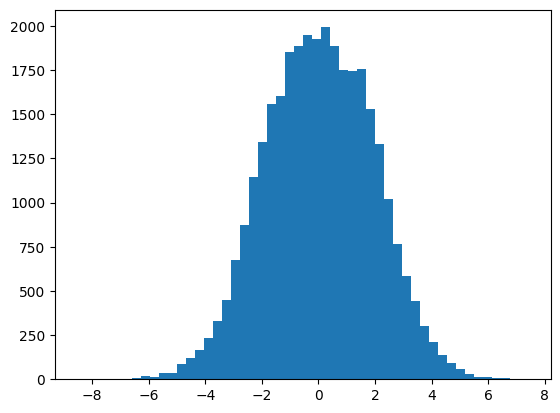

In [421]:
plt.hist(hpreact.view(-1).tolist(), 50);

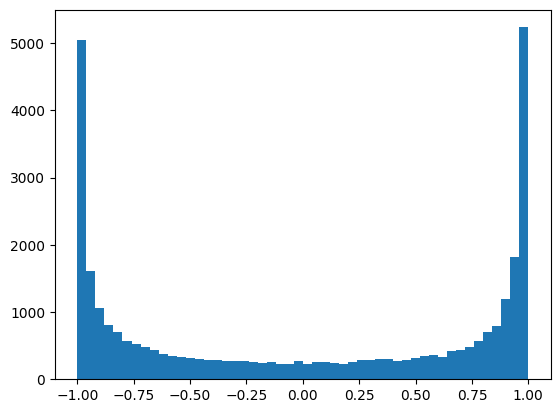

In [422]:
plt.hist(h.view(-1).tolist(), 50);

Text(0, 0.5, 'Loss')

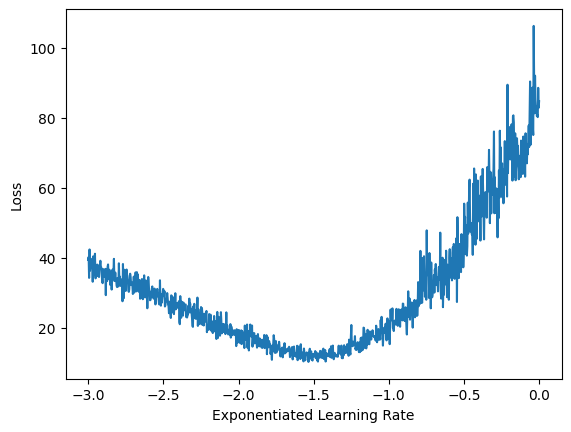

In [423]:
plt.plot(lri, lossi)
plt.xlabel('Exponentiated Learning Rate')
plt.ylabel('Loss')

In [424]:
10 ** -1.5

0.03162277660168379

In [425]:
lossi = []
stepi = []

for i in range(1000):

    # minibatch construct 
    ix = torch.randint(0, X.shape[0], (32, ))

    emb = C[X[ix]] 
    hpreact = emb.view(-1, embedding_dim*block_size) @ W1 + b1

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None    
    loss.backward()
    
    lr = 0.01
    
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())
    

78.32084655761719
78.89708709716797
76.56143188476562
83.55758666992188
82.52991485595703
72.47901916503906
80.74201965332031
78.47982788085938
79.7147445678711
80.62294006347656
70.45669555664062
75.01274871826172
71.25926971435547
78.40986633300781
68.14483642578125
64.0711898803711
64.61477661132812
74.02500915527344
70.7551040649414
82.0355224609375
72.32982635498047
74.49700164794922
79.31291961669922
76.16281127929688
69.14794921875
68.00839233398438
72.7128677368164
67.67738342285156
66.74588012695312
68.34131622314453
67.07750701904297
71.41234588623047
72.4617691040039
69.70376586914062
68.6419906616211
69.21837615966797
78.32455444335938
70.70545196533203
80.88053131103516
76.37737274169922
66.82295989990234
65.5031509399414
72.68167114257812
74.99517822265625
69.53229522705078
86.40711212158203
75.80111694335938
67.10514831542969
65.87094116210938
69.98078155517578
72.721435546875
69.6451416015625
67.76070404052734
71.68763732910156
70.29536437988281
70.5265884399414
71.6233

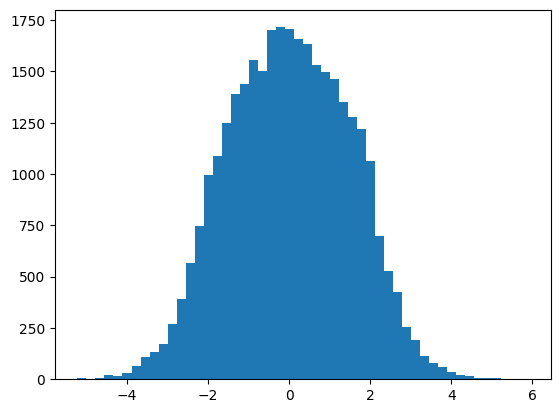

In [426]:
plt.hist(hpreact.view(-1).tolist(), 50);

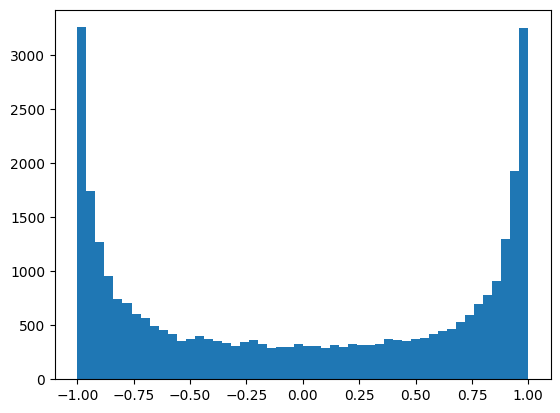

In [427]:
plt.hist(h.view(-1).tolist(), 50);


In [428]:
h.view(-1).shape

torch.Size([32000])

In [429]:
h.shape

torch.Size([32, 1000])

In [430]:
X.shape

torch.Size([650138, 4])

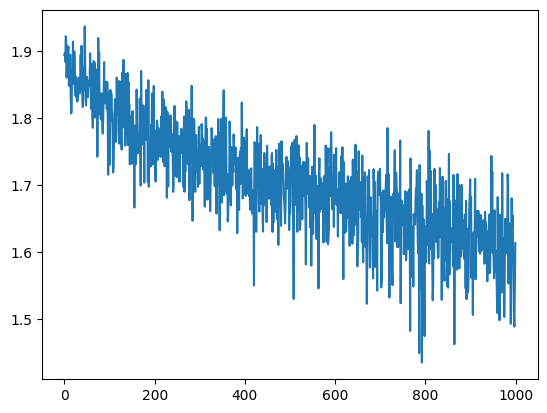

In [431]:
plt.plot(stepi, lossi)

In [432]:
C.shape

torch.Size([21731, 2])

In [433]:
for i, j in sorted_occurrences:
    print(itos[i])

,
the
.
and
to
of
a
he
in
”
his
that
was
with
had
it
her
not
him
at
on
as
!
but
for
she
i
you
is
?
said
all
from
be
were
by
they
who
this
one
which
what
have
prince
so
pierre
an
up
them
or
been
did
when
their
there
would
me
only
are
out
now
no
if
my
could
natásha
man
more
will
andrew
himself
about
into
do
time
then
face
french
princess
went
how
we
some
know
after
before
eyes
old
“i
very
room
thought
men
your
like
see
began
rostóv
again
go
moscow
down
has
came
asked
same
without
still
(
)
looked
those
army
say
count
felt
come
first
away
our
left
over
mary
another
something
life
these
such
seemed
two
nicholas
its
other
head
where
little
day
just
am
hand
whole
than
emperor
should
people
back
long
own
heard
even
way
having
general
napoleon
must
because
any
don’t
saw
being
always
made
russian
look
here
kutúzov
right
can
countess
nothing
young
though
love
suddenly
off
voice
round
us
smile
moment
officer
knew
told
everything
never
took
whom
while
much
words
sónya
looking
house
too
turned
thro

In [434]:
display_no = 200

most_common_tokens = [i[0] for i in sorted_occurrences[:display_no]]

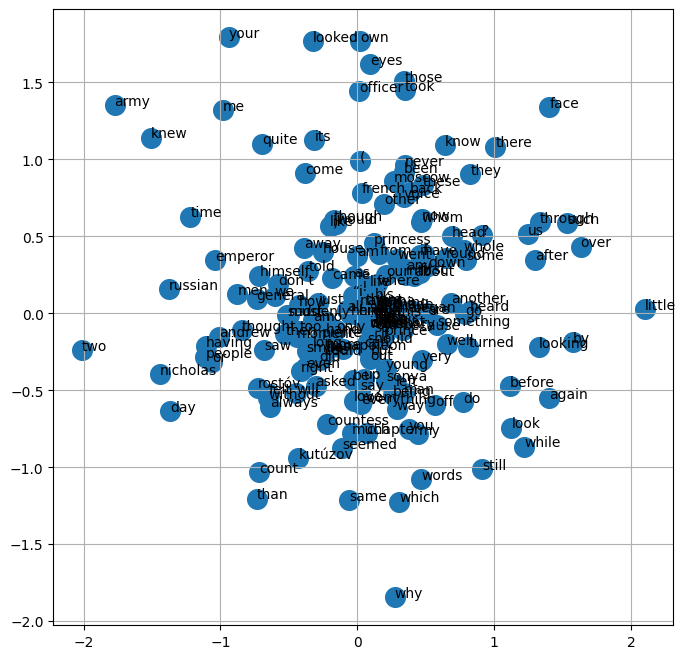

In [435]:
plt.figure(figsize=(8, 8))

# Move the tensors to CPU and convert to numpy for plotting
scatter_x = C[most_common_tokens, 0].cpu().data.numpy()
scatter_y = C[most_common_tokens, 1].cpu().data.numpy()

plt.scatter(scatter_x, scatter_y, s=display_no)
for i in most_common_tokens:
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i])
plt.grid("minor")

In [436]:
for _ in range(10):

    out = []
    context = [11] * block_size  # initialize with all ...
    for i in range(10):
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]

        out.append(ix)


    print(' '.join(itos[i] for i in out))

the the , and the . had , the ,
and , and he ! , . , her the
of , the ! it of , . that had
the that , had his the and the he .
, , to the her of the the his and
, . of to , of , of that ,
the her of . his . the of , the
had , had the had , to of his ,
it to it ! . the the , to it
, his . , the his the , the ,


In [437]:
prompt = "who are you to"

for _ in range(10):
    
    context_words = prompt.split(" ")
    context = [stoi[i] for i in context_words]
    
    out = []
    for i in range(10):
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]

        out.append(ix)


    print(' '.join(itos[i] for i in out))

felt narrow “move valet troops “they tear-worn bellowitz dressed praise
. , the his the had of the of .
. sheds the elohim tear-stained demonstration chroniclers shades did pimples
. that the to his ! his of the he
. he , his his that it his the was
. that the of the was the it that .
. , “how “move all time conscripted eut uncertain zone
. that ? the , got the him his had
. that “how sacks a “nastásya go wisp ” said
. me were was management , . of that and


In [438]:
emb.view(1, -1).shape

torch.Size([1, 8])